# An introductional notebook to HEP analysis using pyROOT

In this notebook, you'll explore computing techniques commonly used in High Energy Physics (HEP) analysis. We'll guide you through creating, filling, and plotting a histogram to visualize physics data, such as the number of leptons, all in under 20 lines of code!


<CENTER>
    <a href="http://opendata.atlas.cern" class="icons"><img src="https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/images/ATLASOD.gif?raw=1" style="width:40%"></a>
</CENTER>

This tutorial also serves as an introduction to [ROOT](https://root.cern.ch/), a scientific data analysis framework. ROOT offers a comprehensive set of tools for big data processing, statistical analysis, visualization, and storage—making it useful for modern HEP research.

The following analysis is looking at events where [Z bosons](https://en.wikipedia.org/wiki/W_and_Z_bosons) decay to two leptons of same flavour and opposite charge, (e.g., Z → e$^+$e$^-$ or Z → μ$^+$μ$^-$), as shown in the [Feynman diagram](https://en.wikipedia.org/wiki/Feynman_diagram).

<CENTER><img src="https://github.com/atlas-outreach-data-tools/notebooks-collection-opendata/blob/master/images/Z_ElectronPositron.png?raw=1" style="width:30%"></CENTER>

## What is the Z Boson?

The Z boson is one of the mediators of the weak force, which is responsible for processes such as [beta decay](https://en.wikipedia.org/wiki/Beta_decay) in atomic nuclei. It interacts with all known fermions (quarks and leptons), but unlike the W boson, it does not change the type (flavor) of particle it interacts with. The Z boson couples to both [left-handed and right-handed](https://en.wikipedia.org/wiki/Chirality_(physics)) particles, making its behavior distinct from the charged W boson.

Since the Z boson is electrically neutral, its decay products must have balanced charges. The decays of the Z boson into leptons (electrons, muons, and taus) are particularly useful for experimental studies because these particles can be precisely measured in detectors, giving a clear signature of the Z boson's presence.

## The Decay of the Z Boson
The Z boson decays rapidly due to its high mass, with a mean lifetime of around 3 × 10$^{-25}$ seconds. Its decay channels include hadrons (quarks) and leptons, but in this analysis, we are particularly interested in the lepton channels because they produce clean final states that are easier to measure.

## Running a Jupyter notebook
A Jupyter notebook consists of cell blocks, each containing lines of Python code. Each cell can be run independently of each other, yielding respective outputs below the cells. Conventionally,cells are run in order from top to bottom.

- To run the whole notebook, in the top menu click Cell $\to$ Run All.
- To propagate a change you've made to a piece of code, click Cell $\to$ Run All Below.
- You can also run a single code cell, by clicking Cell $\to$ Run Cells, or using the keyboard shortcut Shift+Enter.

For more information, refer to [How To Use Jupyter Notebooks](https://www.codecademy.com/article/how-to-use-jupyter-notebooks).

By the end of this notebook you will be able to:
1. Learn to process large data sets using cuts
2. Understand some general principles of a particle physics analysis
3. Discover the Z boson!

## Initializing the notebook
To begin, we need to install the packages that we're going to use. The `ROOT` package is what we'll use for analysis, and `atlasopenmagic` will help us find a file to look into. The exact setup depends a bit on where we're running:
* SWAN and Binder provide environments based on containers that include some of the software we want, while in Colab we need to install it.
* On Binder and SWAN we can use `%jsroot` magic to allow us to interact with the histograms that we draw (e.g. zoom).
* Binder doesn't allow us to use `xrootd` to access files, so we need to access them via the `https` protocol. Using the `ROOT` protocol will allow us to read files that are remote, rather than having to copy them locally before opening them.

You don't need to worry about the details above if you don't understand them, but those are the adjustments we'll make in the next cell.

In [ ]:
# Our environment will depend on whether we're running in Colab, Binder, or SWAN
if 'google.colab' in str(get_ipython()):
    print('Running on Colab - will install ROOT')
    %pip install ROOT
    # Colab allows us to use the (easier) ROOT protocol to read files
    protocol = 'ROOT'
    import ROOT
    %jsroot off
else:
    print('Not running on Colab')
    # On Binder we have to use the https protocol to read files
    protocol = 'https'
    import ROOT
    # But on Binder we can enable jsroot, which lets us interact with the
    # histograms we draw later on
    %jsroot on
%pip install atlasopenmagic

## Making a histogram
We begin by opening the data file we wish to analyze. There's no need to understand the first three lines here, which just get a file for us to play with; if you'd like to understand them better, you can go through the [metadata tutorial](https://opendata.atlas.cern/docs/13TeV25Doc/Concepts#accessing-metadata-new). The data are stored in a ***.root*** file, which consists of a tree structure containing branches and leaves.

In [ ]:
# Use atlasopenmagic to get a file for us to look at
import atlasopenmagic as atom
atom.set_release('2025e-13tev-beta')
file_name = atom.get_urls('700322',protocol=protocol,cache=False)[0]
# Open the file using ROOT
f = ROOT.TFile.Open(file_name)

<div class="alert alert-info">
  <b>‼️ NOTE:</b>
  To learn more about the contents of the ATLAS Open Data datasets, please visit our <a href="https://opendata.atlas.cern/docs/data/for_education/13TeV25_details" target="_blank">documentation.</a>
</div>

Next, we define a tree (we'll name it ***tree***) to extract the data from the ***.root*** file, from the tree called `analysis`, that holds the data.

In [ ]:
tree = f.Get("analysis")
n_events = tree.GetEntries()
print(f"The dataset has {n_events} events")

Now, we create a canvas on which we will draw our histogram. Without a canvas, we won't be able to visualize the histogram - you can think of it as just like a canvas that an artist would draw on. The following command creates a canvas named ***Canvas*** with a title and sets its width and height:

In [4]:
canvas = ROOT.TCanvas("Canvas","a first way to plot a variable",800,600)

We also need to define the histogram that will be placed on this canvas. The histogram is named **lepton_histogram** and its title is **"Number of leptons"**. It has 5 bins that span the range from -0.5 to 4.5 (for a total range of 0 to 4 leptons; using these bins that are offset by 0.5 from integers means that we'll see the number of leptons directly below the corresponding bin):

In [5]:
hist = ROOT.TH1F("lepton_histogram","Number of leptons; Number of leptons ; Events ",5,-0.5,4.5)

The following lines are a loop that goes over the data that are stored in the tree and fills the histogram (h) that we already defined. The loop fills the histogram for each event stored in the tree. We stop the loop after 100,000 events just to keep things fast; you can run over more events if you wish. After the program has looped over all the data it prints "Done!"

In [ ]:
# Loop over the events in our tree
for nEvent,event in enumerate(tree):
    # Fill the histogram with the number of leptons
    hist.Fill(tree.lep_n)
    # Stop early so that the job finishes quickly (it's a lot of events!!)
    if nEvent >= 100000:
        break

print("Done!")

After filling the histogram we want to draw it on the canvas, and then we need to draw (display, basically) the canvas on which the histogram lies.

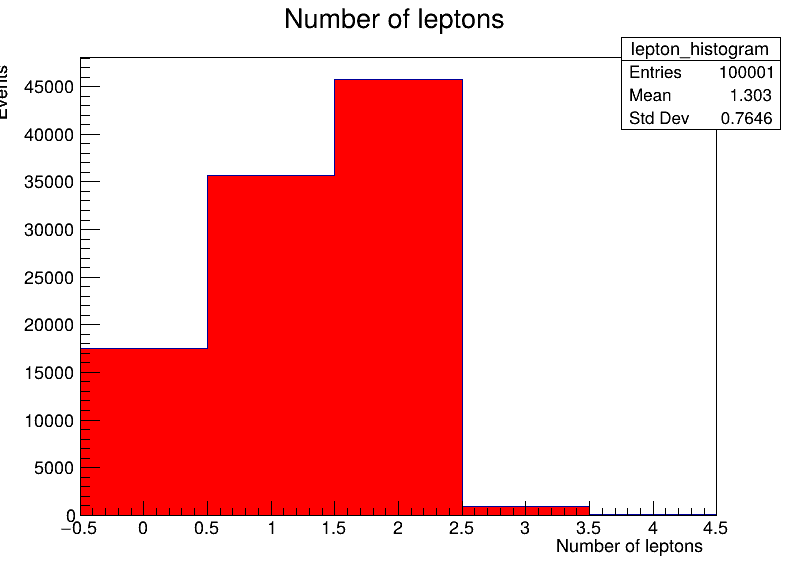

In [7]:
hist.SetFillColor(2)
hist.Draw()
canvas.Draw()

### Interpreting the histogram
In the plot above, we visualize the distribution of the number of leptons per event. This histogram provides insight into the frequency of events containing different numbers of leptons.

- **X-axis**: Represents the number of leptons detected in each event. The values range from 0 to 4, where each bin corresponds to an integer number of leptons.
- **Y-axis**: Shows the number of events that contain the corresponding number of leptons.

From the data:

- The majority of events contain either 1 or 2 leptons, with the peak occurring at 2 leptons, suggesting that this number of leptons is the most common in the analyzed dataset.
- Events with 0, 3, or 4 leptons are significantly less frequent, as indicated by the lower heights of their corresponding bins.

In the statistics box on the top right:

- We see that the total number of events analyzed is 100,001.
- The mean number of leptons per event is around 1.303, indicating that most events contain between 1 and 2 leptons on average.
- The standard deviation of around 0.76 shows a modest spread, meaning that the events are spread over several bins.

This histogram gives us a snapshot of the lepton content in the events, which can be further analyzed to study processes like lepton production in proton-proton collisions at high energies. The distribution is an important aspect of understanding the data and may inform further cuts or selection criteria for a complex physics analysis.

<div class="alert alert-block alert-info">
We welcome your feedback on this notebook or any of our other materials! Please <a href="https://forms.gle/zKBqS1opAHHemv9U7">fill out this survey</a> to let us know how we're doing, and you can enter a raffle to win some <a href="https://atlas-secretariat.web.cern.ch/merchandise">ATLAS merchandise</a>!
</div>